In [1]:
import sys
sys.path.append("/home/julian/repositories")

from wingshape import WingShape
from parapolygraph import ParamPolyGraph
import numpy, math

wingshape = WingShape("P7-211221-XYZ geometry.csv")        
parapolygraph = ParamPolyGraph(wingshape, "test7.json", splineweight=0.8, legsampleleng=0.003)


In [2]:
from barmesh.basicgeo import I1, Partition1

parapolygraph.splineinterplegsdata()
polysnodes = parapolygraph.derivepolygons()
surfacemeshes = [ ]
for i, polynodes in enumerate(polysnodes):
    polyloop = parapolygraph.splinedpolypoints(polynodes)
    polyloopW = [ wingshape.seval(p)  for p in polyloop ]
    surfacemesh = { "polynodes":polynodes, 
                    "polyloop":polyloop,
                    "plurg":I1.AbsorbList(p[0]  for p in polyloop), 
                    "plvrg":I1.AbsorbList(p[1]  for p in polyloop),
                    "polyloopW":polyloopW 
                  }
    surfacemeshes.append(surfacemesh)


In [22]:
from barmesh.tribarmes import TriangleBarMesh, TriangleBar, MakeTriangleBoxing
from wingflatten_barmeshfuncs import ImplicitAreaBallOffsetOfClosedContour
#from barmesh import implicitareaballoffset
from wingflatten_barmeshfuncs import MakeRectBarmeshForWingParametrization
from barmesh.barmeshslicer import BarMeshSlicer
from barmesh.mainfunctions import nodewithinpairs, BarMeshContoursN
from barmesh.basicgeo import I1, Partition1


def barmeshoffset(polyloop, polyloopW, radoffset, uspacing, vspacing):
    iaoffset = ImplicitAreaBallOffsetOfClosedContour(polyloopW, polyloop)
    
    urg = I1.AbsorbList(p[0]  for p in polyloop).Inflate(0.05)
    vrg = I1.AbsorbList(p[1]  for p in polyloop).Inflate(0.05)
    xpart = Partition1(urg.lo, urg.hi, int(urg.Leng()/uspacing + 2))
    ypart = Partition1(vrg.lo, vrg.hi, int(vrg.Leng()/vspacing + 2))

    bm = MakeRectBarmeshForWingParametrization(wingshape, xpart, ypart)
    rd2 = max(uspacing, vspacing, radoffset*2) + 0.01
    contourdelta = min(uspacing, vspacing)*0.2
    bms = BarMeshSlicer(bm, iaoffset, rd=radoffset, rd2=rd2, contourdotdiff=0.95, contourdelta=contourdelta, lamendgap=0.001, strictlyplanarbarmesh=False)

    #bms.initializecutsanddistances()
    bms.fullmakeslice()
    return bm

for i in range(len(surfacemeshes)):
    print("\nStarting", i)
    surfacemesh = surfacemeshes[i]
    polyloop, polyloopW = surfacemesh["polyloop"], surfacemesh["polyloopW"]
    surfacemesh["barmeshoffset"] = barmeshoffset(polyloop, polyloopW, radoffset=0.006, uspacing=0.02, vspacing=0.02)



Starting 0
make triangle boxing at 0.047043302883781335
make triangle boxing at 0.09837810040904771
MakePointZoneRFS done on 3040 nodes
do splitbarsdirectionchangesR on 5953 bars
done splitbarsdirectionchangesR
Ready for barpolycutsrounds  230
nsegs: 253 bad: 0 working: 0
111 [15, 10, 25, 0, 15, 6, 20, 0, 10, 10, 0, 0, 0, 0, 0]

Starting 1
make triangle boxing at 0.04245011031816404
make triangle boxing at 0.06165027625633657
MakePointZoneRFS done on 5244 nodes
do splitbarsdirectionchangesR on 10237 bars
done splitbarsdirectionchangesR
Ready for barpolycutsrounds  482
nsegs: 498 bad: 0 working: 0
76 [15, 15, 10, 5, 10, 3, 8, 0, 5, 5, 0, 0, 0, 0]

Starting 2
make triangle boxing at 0.052358552582613564
make triangle boxing at 0.09837810040904771
MakePointZoneRFS done on 1696 nodes
do splitbarsdirectionchangesR on 3307 bars
done splitbarsdirectionchangesR
Ready for barpolycutsrounds  146
nsegs: 169 bad: 0 working: 0
111 [15, 10, 25, 0, 15, 6, 20, 0, 10, 10, 0, 0, 0, 0, 0]

Starting 3
ma

In [26]:
from barmesh import barmesh

for i in range(len(surfacemeshes)):
    surfacemesh = surfacemeshes[i]
    bm = surfacemesh["barmeshoffset"]
    contsN, topbars = BarMeshContoursN(bm, barmesh.PZ_BEYOND_R)
    assert len(contsN) == 1
    outercont = contsN[0]
    outercont.append(outercont[0])
    surfacemesh["offsetloopuv"] = [n.sp for n in outercont]
    surfacemesh["offsetlooppts"] = [n.p for n in outercont]



<IPython.core.display.Javascript object>


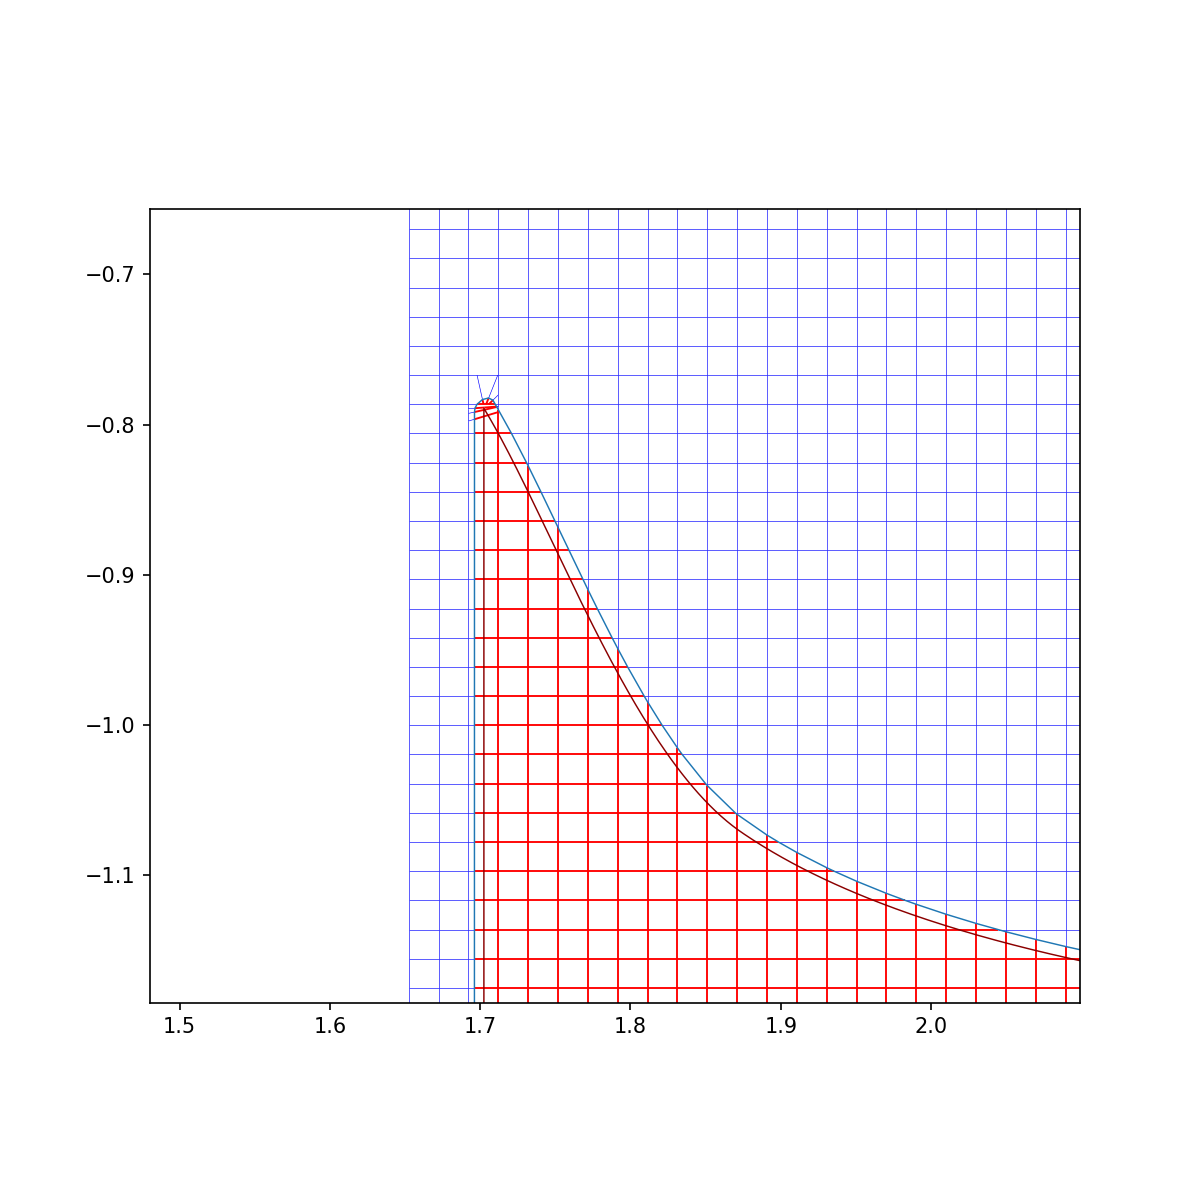

In [55]:
%matplotlib notebook

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.collections import LineCollection
from barmesh.mainfunctions import nodewithinpairs

plt.figure(figsize=(8,8))

surfacemesh = surfacemeshes[6]
bm = surfacemesh["barmeshoffset"]

#segmentswithin = [ [(n0.p[0], n0.p[1]), (n1.p[0], n1.p[1])]  for n0, n1 in nodewithinpairs(bm, True) ]
segmentswithin = [ [(n0.sp[0], n0.sp[1]), (n1.sp[0], n1.sp[1])]  for n0, n1 in nodewithinpairs(bm, True) ]
lc = LineCollection(segmentswithin, color="red", linewidth=0.9)
plt.gca().add_collection(lc)

segmentswithin = [ [(n0.sp[0], n0.sp[1]), (n1.sp[0], n1.sp[1])]  for n0, n1 in nodewithinpairs(bm, False) ]
lc = LineCollection(segmentswithin, color="blue", linewidth=0.3)
plt.gca().add_collection(lc)


sps = surfacemesh["offsetloopuv"]
plt.plot([sp[0] for sp in sps], [sp[1] for sp in sps], linewidth=0.7)

polyloop = surfacemesh["polyloop"]
plt.plot([sp[0] for sp in polyloop], [sp[1] for sp in polyloop], linewidth=0.7, color="darkred")


plt.gca().set_aspect("equal")
plt.gca().autoscale()

In [38]:
len(surfacemeshes)

16

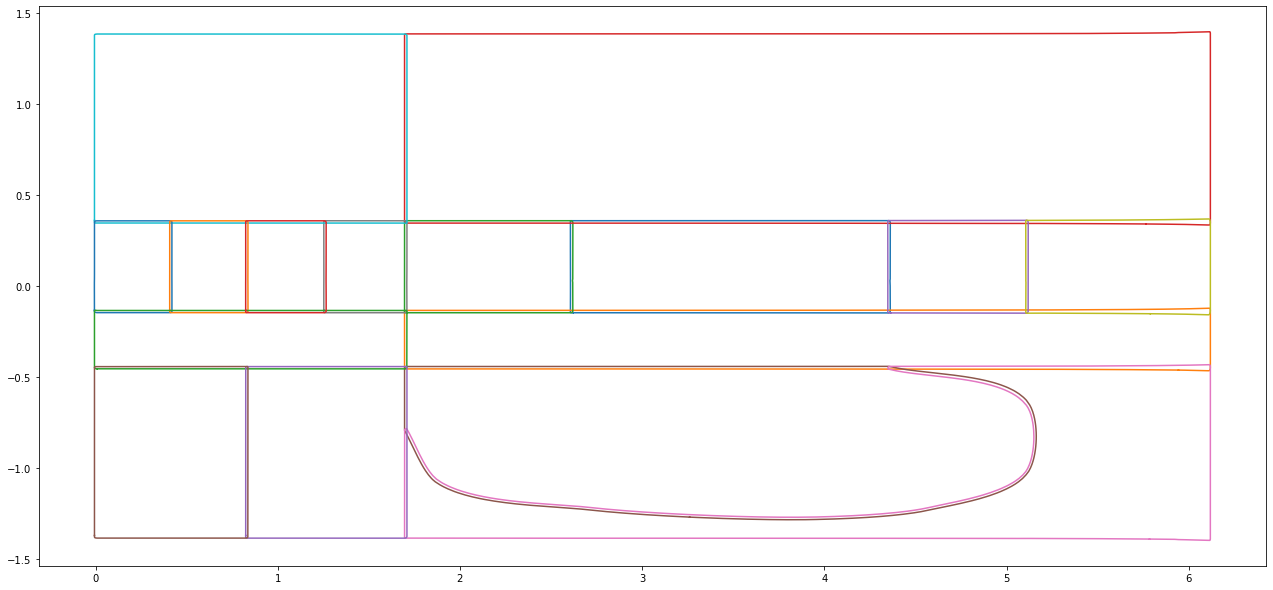

In [43]:
%matplotlib inline 

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

plt.figure(figsize=(22,18))
for i in range(len(surfacemeshes)):
    surfacemesh = surfacemeshes[i]
    sps = surfacemesh["offsetloopuv"]
    plt.plot([sp[0] for sp in sps], [sp[1] for sp in sps])
plt.gca().autoscale()
plt.gca().set_aspect("equal")


<IPython.core.display.Javascript object>


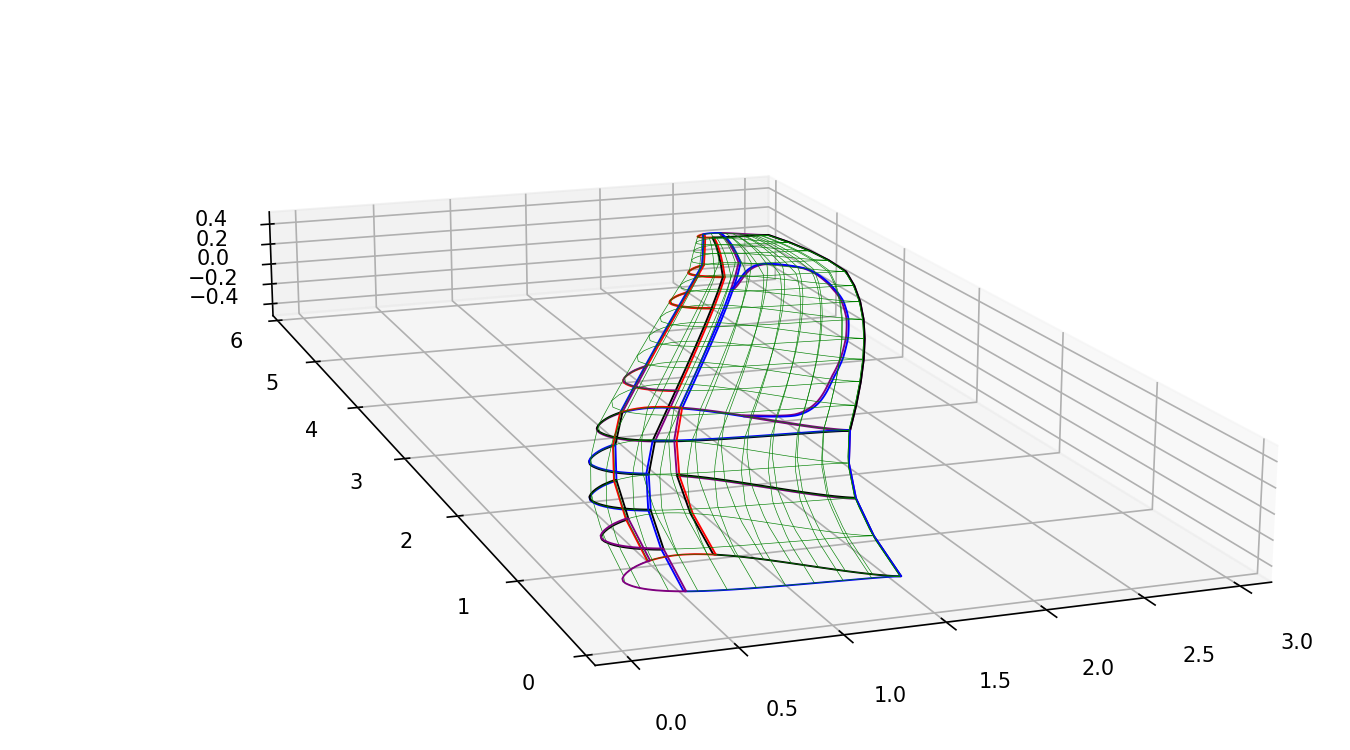

(0.0, 6.0)

In [44]:
%matplotlib notebook

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import numpy

def flipyz(p):
    return (p.x, p.z, p.y)

fig = plt.figure(figsize=(9,5))
ax3d = fig.add_subplot(1,1,1, projection='3d')
ax3d.set_box_aspect([1,2,0.2], zoom=2.3)

ax3d.add_collection(Line3DCollection(wingshape.linesegmentnetflipyz(flipyz), color="green", linewidth=0.3))

cols = ["red", "blue", "purple", "black"]
for i in range(len(surfacemeshes)):
    surfacemesh = surfacemeshes[i]
    ps = surfacemesh["offsetlooppts"]
    segpolys = [ ]
    segpolys.append([flipyz(p)  for p in ps])
    lp3d = Line3DCollection(segpolys, color=cols[0], linewidth=0.9)
    ax3d.add_collection(lp3d)
    cols = cols[1:]+[cols[0]]
ax3d.set_aspect('auto')
ax3d.set_clip_on(False)
ax3d.autoscale_view()
ax3d.set_xlim3d(-0.1, 3.1)
ax3d.set_zlim3d(-0.5, 0.5)
ax3d.set_ylim3d(0, 6)